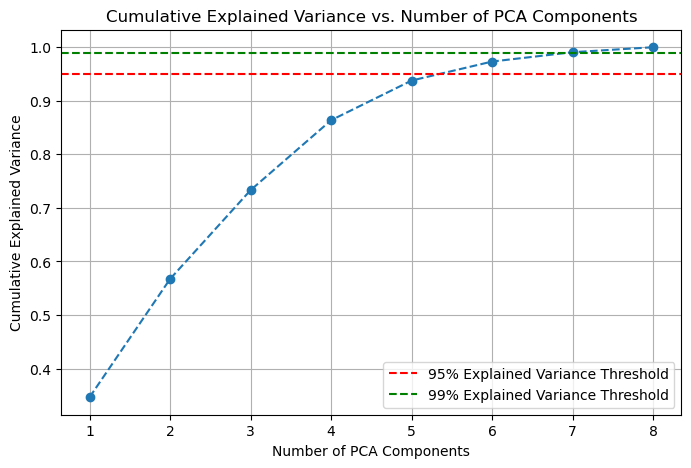

Performing 5-Fold Cross-Validation:

Evaluating Naive Bayes with cross-validation...
Naive Bayes - Mean Test Accuracy: 0.751, Mean Test AUC: 0.706
Mean Train Accuracy: 0.952, Mean Train AUC: 0.963


Evaluating SVM with cross-validation...
SVM - Mean Test Accuracy: 0.809, Mean Test AUC: 0.889
Mean Train Accuracy: 0.928, Mean Train AUC: 0.987


Evaluating Random Forest with cross-validation...
Random Forest - Mean Test Accuracy: 0.819, Mean Test AUC: 0.899
Mean Train Accuracy: 1.000, Mean Train AUC: 1.000



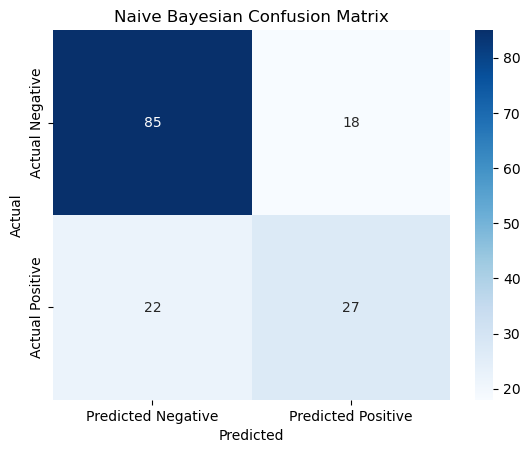

Classification Report Naive Bayesian:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       103
           1       0.60      0.55      0.57        49

    accuracy                           0.74       152
   macro avg       0.70      0.69      0.69       152
weighted avg       0.73      0.74      0.73       152

AUC: 0.69
Log Loss: 9.49


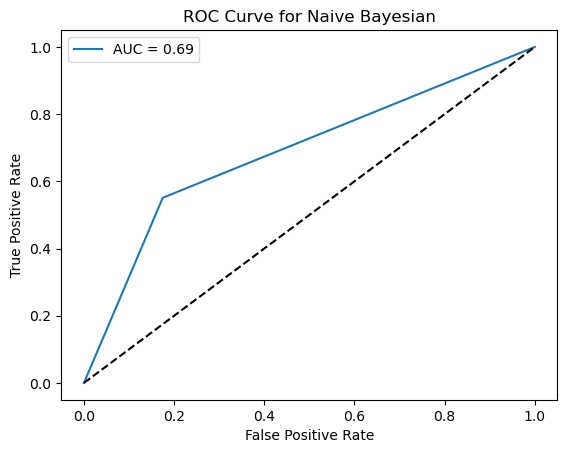

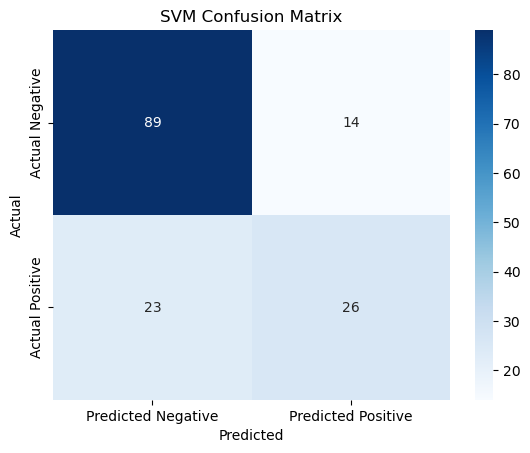

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       103
           1       0.65      0.53      0.58        49

    accuracy                           0.76       152
   macro avg       0.72      0.70      0.71       152
weighted avg       0.75      0.76      0.75       152

SVM AUC: 0.83
SVM Log Loss: 0.53


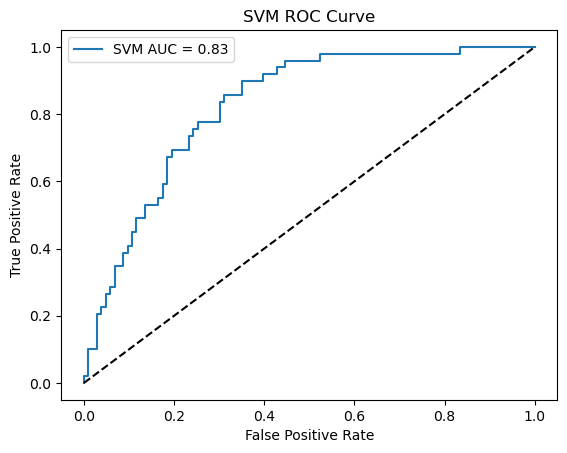

Random forest model hyperparameter tuning: best parameters found:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Calibrated Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       103
           1       0.63      0.67      0.65        49

    accuracy                           0.77       152
   macro avg       0.74      0.74      0.74       152
weighted avg       0.77      0.77      0.77       152



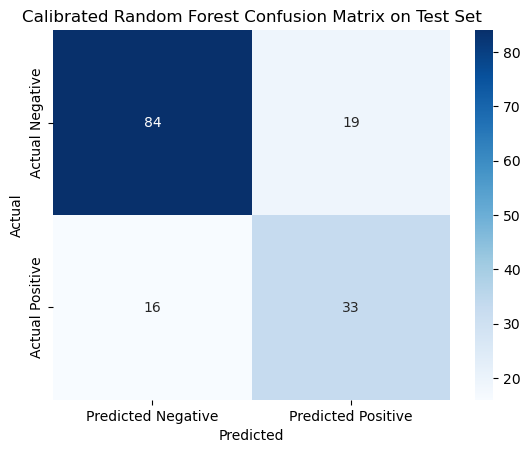

Calibrated Random Forest Test Set AUC: 0.85
Calibrated Random Forest Test Set Log Loss: 0.46


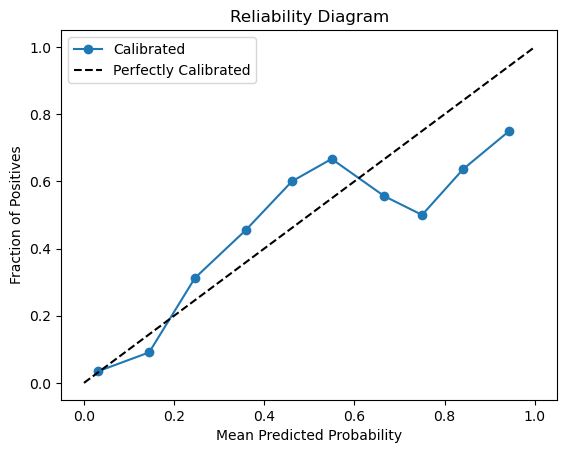

Out-of-domain instances: 3 out of 152
In-domain Classification Report (Calibrated):
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       101
           1       0.63      0.67      0.65        48

    accuracy                           0.77       149
   macro avg       0.73      0.74      0.74       149
weighted avg       0.77      0.77      0.77       149

Out-of-domain Classification Report (Calibrated):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



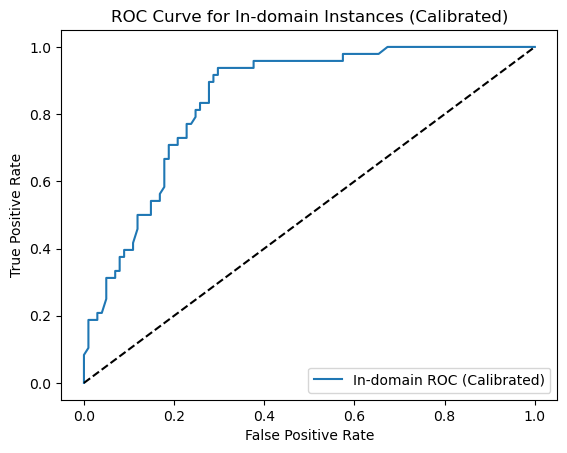

Validation of the calibrated random forest model on the unseen database:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       462
           1       0.25      0.16      0.19       109

    accuracy                           0.75       571
   macro avg       0.53      0.52      0.52       571
weighted avg       0.71      0.75      0.72       571



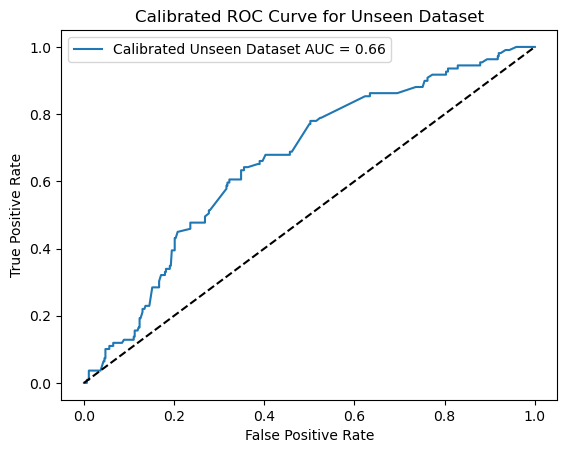

Calibrated Unseen Dataset AUC: 0.66
Calibrated Unseen Dataset Log Loss: 0.52
Calibrated Unseen Dataset Classification Report (In-Domain):
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       172
           1       0.24      0.24      0.24        29

    accuracy                           0.78       201
   macro avg       0.56      0.56      0.56       201
weighted avg       0.78      0.78      0.78       201

Calibrated Unseen Dataset Classification Report (Out-of-Domain):
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       290
           1       0.25      0.12      0.17        80

    accuracy                           0.73       370
   macro avg       0.52      0.51      0.50       370
weighted avg       0.67      0.73      0.69       370



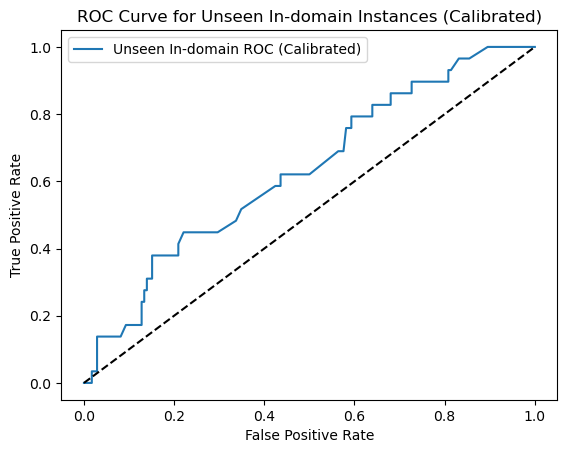

Calibrated Unseen In-domain AUC: 0.63
Calibrated Unseen In-domain Log Loss: 0.48


In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools, AllChem, DataStructs, rdFingerprintGenerator
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss



# Load SDF file and convert to DataFrame
sdf_file = 'trainingset_pruned_759compounds.sdf'
sdf_supplier = Chem.SDMolSupplier(sdf_file)
df = PandasTools.LoadSDF(sdf_file, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# Define the descriptors calculation function
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:  # Check if molecule conversion is successful
        return {}
    descriptors = {
        'ALogP': Descriptors.MolLogP(mol),
        'MolecularWeight': Descriptors.MolWt(mol),
        'NumRings': Descriptors.RingCount(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'NumHBDonors': Descriptors.NumHDonors(mol),
        'NumHBAcceptors': Descriptors.NumHAcceptors(mol),
        'MolecularFractionalPolarSurfaceArea': Descriptors.FractionCSP3(mol)  
    }
    return descriptors

# Calculate descriptors
df['Descriptors'] = df['SMILES'].apply(calculate_descriptors)
df_descriptors = df['Descriptors'].apply(pd.Series)

# Morgan fingerprint calculation
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3)
def calculate_fcfp6(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fcfp6 = morgan_gen.GetFingerprint(mol)
    array = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fcfp6, array)
    return array

# Calculate fingerprints
fcfp6_data = df['SMILES'].apply(calculate_fcfp6)
fcfp6_df = pd.DataFrame(fcfp6_data.tolist(), index=df.index)

# Concatenate original features with Morgan fingerprints
selected_descriptor_columns = df_descriptors.columns.tolist()
features = df_descriptors.join(fcfp6_df).dropna()

# Extract the target variable 'Stable'
target_column = 'Stable'
labels = df[target_column].loc[features.index].astype(int)

# Standardizing the descriptor features
scaler = StandardScaler()
scaled_descriptors = scaler.fit_transform(features[selected_descriptor_columns])

# Apply PCA to scaled descriptor features
pca = PCA(n_components=5)
principal_components = pca.fit_transform(scaled_descriptors)

# Compute cumulative explained variance for all components
pca_full = PCA().fit(scaled_descriptors)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(selected_descriptor_columns) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of PCA Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance Threshold')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Explained Variance Threshold')
plt.legend()
plt.grid()
plt.show()

# Combine PCA transformed descriptors with original Morgan fingerprints
combined_features = np.hstack((principal_components, fcfp6_df.loc[features.index].values))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, labels, test_size=0.2, random_state=42)

# Cross-validation setup to determine which model is the best for further optimization: Naive Bayesian, SVM, Random Forest
models = {
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
}
cv_results = {}
print("Performing 5-Fold Cross-Validation:")
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} with cross-validation...")
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'roc_auc'], return_train_score=True)
    cv_results[model_name] = scores
    print(f"{model_name} - Mean Test Accuracy: {scores['test_accuracy'].mean():.3f}, Mean Test AUC: {scores['test_roc_auc'].mean():.3f}")
    print(f"Mean Train Accuracy: {scores['train_accuracy'].mean():.3f}, Mean Train AUC: {scores['train_roc_auc'].mean():.3f}\n")



# 1. Naive Bayesian Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict and evaluate the Bayesian model
y_pred = nb_model.predict(X_test)
y_prob = nb_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], 
yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Naive Bayesian Confusion Matrix')
plt.show()

# Evaluate model
print("Classification Report Naive Bayesian:")
print(classification_report(y_test, y_pred))
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc_score:.2f}")
logloss = log_loss(y_test, y_prob)
print(f"Log Loss: {logloss:.2f}")


y_test = y_test.astype(int)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayesian')
plt.legend()
plt.show()


# 2. SVM model
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
y_prob_svc = svc_model.predict_proba(X_test)[:, 1]
y_pred_svc = y_pred_svc.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM Confusion Matrix')
plt.show()
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svc))
auc_score_svc = roc_auc_score(y_test, y_prob_svc)
print(f"SVM AUC: {auc_score_svc:.2f}")
logloss_svc = log_loss(y_test, y_prob_svc)
print(f"SVM Log Loss: {logloss_svc:.2f}")

fpr_svc, tpr_svc, _ = roc_curve(y_test, y_prob_svc)
plt.plot(fpr_svc, tpr_svc, label=f'SVM AUC = {auc_score_svc:.2f}')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend()
plt.show()



# 3. Random forest model with hyperparameter optimization (tuning)
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, 
cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
print("Random forest model hyperparameter tuning: best parameters found: ", random_search.best_params_)

best_rf_model = random_search.best_estimator_
# Calibrate the best model
calibrated_rf_model = CalibratedClassifierCV(best_rf_model, method='isotonic', cv=5)  
calibrated_rf_model.fit(X_train, y_train)

# Predict with the calibrated model
y_prob_calibrated = calibrated_rf_model.predict_proba(X_test)[:, 1]
y_pred_calibrated = calibrated_rf_model.predict(X_test)

# Classification report for the calibrated model
print("Calibrated Random Forest Classification Report on Test Set:")
print(classification_report(y_test, y_pred_calibrated))

# Confusion Matrix for the calibrated Random Forest model
cm_calibrated = confusion_matrix(y_test, y_pred_calibrated)
sns.heatmap(cm_calibrated, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Calibrated Random Forest Confusion Matrix on Test Set')
plt.show()

# AUC and Log Loss for the calibrated Random Forest model
auc_score_calibrated = roc_auc_score(y_test, y_prob_calibrated)
print(f"Calibrated Random Forest Test Set AUC: {auc_score_calibrated:.2f}")
logloss_calibrated = log_loss(y_test, y_prob_calibrated)
print(f"Calibrated Random Forest Test Set Log Loss: {logloss_calibrated:.2f}")

# Reliability Diagram
prob_true, prob_pred = calibration_curve(y_test, y_prob_calibrated, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.legend()
plt.show()


# Applicability domain using Nearest Neighbors
knn = NearestNeighbors(n_neighbors=5).fit(X_train)
distances, _ = knn.kneighbors(X_test)
threshold = np.percentile(distances, 95)
out_of_domain = distances.mean(axis=1) > threshold

print(f"Out-of-domain instances: {np.sum(out_of_domain)} out of {len(y_test)}")

# Separate analysis for in-domain and out-of-domain predictions
in_domain_idx = ~out_of_domain
out_domain_idx = out_of_domain

# In-Domain Evaluations
print("In-domain Classification Report (Calibrated):")
print(classification_report(y_test[in_domain_idx], y_pred_calibrated[in_domain_idx]))

# Out-of-Domain Evaluations
print("Out-of-domain Classification Report (Calibrated):")
if np.any(out_domain_idx):
    print(classification_report(y_test[out_domain_idx], y_pred_calibrated[out_domain_idx]))
else:
    print("No out-of-domain instances.")

# ROC Curve for in-domain predictions using calibrated probabilities
fpr_in, tpr_in, _ = roc_curve(y_test[in_domain_idx], y_prob_calibrated[in_domain_idx])
plt.plot(fpr_in, tpr_in, label='In-domain ROC (Calibrated)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for In-domain Instances (Calibrated)')
plt.legend()
plt.show()


# Applying the calibrated random forest model to a second unseen dataset (a test set containing 571 compounds)

# Load Unseen Data from SDF
sdf_file_unseen = 'test_set_571compounds.sdf'
df_unseen = PandasTools.LoadSDF(sdf_file_unseen, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)
df_unseen['Descriptors'] = df_unseen['SMILES'].apply(calculate_descriptors)
df_descriptors_unseen = df_unseen['Descriptors'].apply(pd.Series)
fcfp6_data_unseen = df_unseen['SMILES'].apply(calculate_fcfp6)
fcfp6_df_unseen = pd.DataFrame(fcfp6_data_unseen.tolist(), index=df_unseen.index)
selected_descriptor_columns = df_descriptors_unseen.columns.tolist()
scaled_descriptors_unseen = scaler.transform(df_descriptors_unseen[selected_descriptor_columns])
principal_components_unseen = pca.transform(scaled_descriptors_unseen)
combined_features_unseen = np.hstack((principal_components_unseen, fcfp6_df_unseen.values))
y_unseen = df_unseen['Stable'].astype(int)

# Predict using the calibrated random forest model
y_pred_unseen_calibrated = calibrated_rf_model.predict(combined_features_unseen)
y_prob_unseen_calibrated = calibrated_rf_model.predict_proba(combined_features_unseen)[:, 1]

# Evaluate predictions on the unseen dataset
print("Validation of the calibrated random forest model on the unseen database:")
print(classification_report(y_unseen, y_pred_unseen_calibrated))

# ROC Curve for the predictions
fpr_unseen, tpr_unseen, _ = roc_curve(y_unseen, y_prob_unseen_calibrated)
plt.plot(fpr_unseen, tpr_unseen, label=f'Calibrated Unseen Dataset AUC = {roc_auc_score(y_unseen, y_prob_unseen_calibrated):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Calibrated ROC Curve for Unseen Dataset')
plt.legend()
plt.show()

# Overall AUC and Log Loss
auc_score_unseen_calibrated = roc_auc_score(y_unseen, y_prob_unseen_calibrated)
logloss_unseen_calibrated = log_loss(y_unseen, y_prob_unseen_calibrated)
print(f"Calibrated Unseen Dataset AUC: {auc_score_unseen_calibrated:.2f}")
print(f"Calibrated Unseen Dataset Log Loss: {logloss_unseen_calibrated:.2f}")

# Use Nearest Neighbors from previously fitted training data
distances_unseen, _ = knn.kneighbors(combined_features_unseen)
out_of_domain_unseen = distances_unseen.mean(axis=1) > threshold

# Separate predictions into in-domain and out-of-domain
print("Calibrated Unseen Dataset Classification Report (In-Domain):")
print(classification_report(y_unseen[~out_of_domain_unseen], y_pred_unseen_calibrated[~out_of_domain_unseen]))

print("Calibrated Unseen Dataset Classification Report (Out-of-Domain):")
if np.any(out_of_domain_unseen):
    print(classification_report(y_unseen[out_of_domain_unseen], y_pred_unseen_calibrated[out_of_domain_unseen]))
else:
    print("No out-of-domain instances in the unseen dataset.")

# In-domain ROC for the calibrated predictions
fpr_unseen_indomain, tpr_unseen_indomain, _ = roc_curve(y_unseen[~out_of_domain_unseen], y_prob_unseen_calibrated[~out_of_domain_unseen])
plt.plot(fpr_unseen_indomain, tpr_unseen_indomain, label='Unseen In-domain ROC (Calibrated)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Unseen In-domain Instances (Calibrated)')
plt.legend()
plt.show()

# Calculate AUC and Log Loss for in-domain data
auc_score_unseen_indomain_calibrated = roc_auc_score(y_unseen[~out_of_domain_unseen], y_prob_unseen_calibrated[~out_of_domain_unseen])
logloss_unseen_indomain_calibrated = log_loss(y_unseen[~out_of_domain_unseen], y_prob_unseen_calibrated[~out_of_domain_unseen])
print(f"Calibrated Unseen In-domain AUC: {auc_score_unseen_indomain_calibrated:.2f}")
print(f"Calibrated Unseen In-domain Log Loss: {logloss_unseen_indomain_calibrated:.2f}")






